In [1]:
from katsu.katsu_math import np, set_backend_to_jax, broadcast_kron
from katsu.mueller import linear_polarizer, linear_retarder

set_backend_to_jax()

import jax
jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
from jax import random
from jax.scipy.special import factorial
import numpy as tnp

# Set up Illuminated Aperture

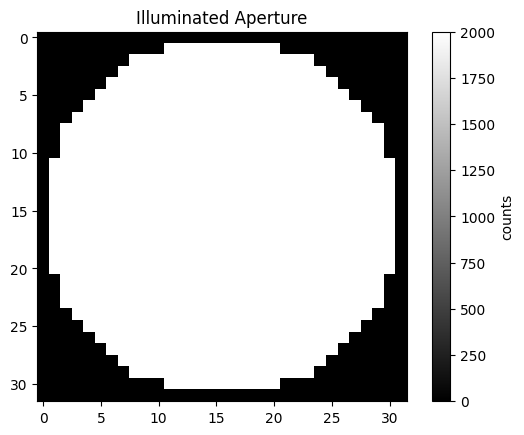

In [2]:
# set up simulation parameters for spatially-varying data
NPIX = 32
N_PHOTONS = 2000

# set up illuminated pupil
x = np.linspace(-1, 1, NPIX)
x, y = np.meshgrid(x, x)
r = np.sqrt(x**2 + y**2)
mask = np.zeros_like(r)
mask = mask.at[r < 1].set(1)
aperture = mask * N_PHOTONS

plt.figure()
plt.title("Illuminated Aperture")
plt.imshow(aperture, cmap='grey')
plt.colorbar(label='counts')
plt.show()

# Set up Noisy Detector

This will be Poisson-dominated

In [3]:
def add_camera_noise(Nphotons, qe=1., dark_current=0, bitdepth=12, seed=random.key(42)):
    """Simulate a camera exposure

    function from http://kmdouglass.github.io/posts/modeling-noise-for-image-simulations/
    with modifications to support Jax behavior

    Parameters
    ----------
    Nphotons : int
        number of photons incident on a camera pixel
    qe : float, optional
        electrons per photon, by default 0.69
    dark_current : float, optional
        standard deviation of electrons, by default 2.29
    bitdepth : int, optional
        number of bits detector can resolve, by default 12
    seed : np.random.RandomState, optional
        random seed for simulation, by default np.random.RandomState(seed=42)
    """
    # photon noise
    photons = random.poisson(seed, Nphotons)

    # convert to electrons
    electrons = qe * photons

    # dark current
    electrons_out = random.normal(seed) / 1e3 + electrons

    # ADU
    max_adu = int(2**bitdepth - 1)
    adu = (electrons_out).astype(int)
    adu = adu.at[adu > max_adu].set(max_adu)

    return adu

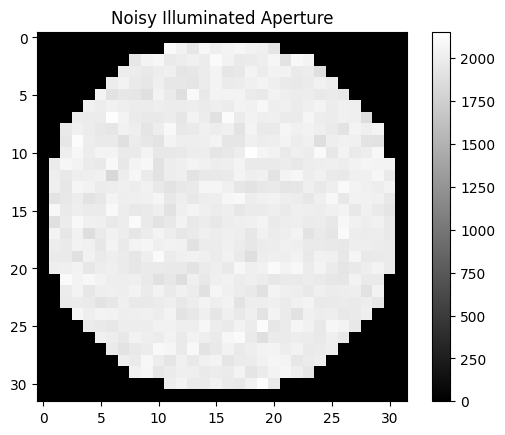

In [4]:
plt.figure()
plt.title("Noisy Illuminated Aperture")
plt.imshow(add_camera_noise(aperture), cmap='grey')
plt.colorbar()
plt.show()

# Generate a Spatially-resolved forward model

This will be a function of the illumination and model parameters

In [5]:
STEPS_DEG = 2.5
ANGULAR_RATIO = 2.5

def measurement(x, noisy=True):
    """Create simulated power measurement

    Parameters
    ----------
    x : list or array
        vector of model parameters

    Returns
    -------
    array
        simulated power array of shape NPIX x NPIX x N_ROTATIONS
    """

    starting_angle_psg_pol = x[0]
    starting_angle_psg_wvp = x[1]
    retardance_psg_wvp = x[2]
    increment_psg_wvp = 1 # x[3]

    starting_angle_psa_pol = x[4]
    starting_angle_psa_wvp = x[5]
    retardance_psa_wvp = x[6]
    increment_psa_wvp = 1 # x[7]

    # set up PSG angles
    psg_angles = np.arange(0, 181 + STEPS_DEG, STEPS_DEG) * increment_psg_wvp
    psg_angles = np.radians(psg_angles) + starting_angle_psg_wvp

    psa_angles = np.arange(0, (181 + STEPS_DEG)*ANGULAR_RATIO, STEPS_DEG * ANGULAR_RATIO) * increment_psa_wvp
    psa_angles = np.radians(psa_angles) + starting_angle_psa_wvp

    shapes = [NPIX, NPIX, psa_angles.shape[0]]

    psg_pol = linear_polarizer(starting_angle_psg_pol)
    psg_wvp = linear_retarder(psg_angles, retardance_psg_wvp, shape=shapes)

    psa_wvp = linear_retarder(psa_angles, retardance_psa_wvp, shape=shapes)
    psa_pol = linear_polarizer(starting_angle_psa_pol)

    Mg = psg_wvp @ psg_pol
    Ma = psa_pol @ psa_wvp
    M = Ma @ Mg

    if noisy:
        power = []
        _p = M[..., 0, 0]
        _p = np.moveaxis(_p, -1, 0)

        for p in _p:
            power.append(add_camera_noise(p * N_PHOTONS))

        power = np.asarray(power)

    else:
        power = M[..., 0, 0] * N_PHOTONS


    return power

def calibrated_measurement(x, power):

    starting_angle_psg_pol = x[0]
    starting_angle_psg_wvp = x[1]
    retardance_psg_wvp = x[2]
    increment_psg_wvp = 1 # x[3]

    starting_angle_psa_pol = x[4]
    starting_angle_psa_wvp = x[5]
    retardance_psa_wvp = x[6]
    increment_psa_wvp = 1 # x[7]

    # set up PSG angles
    psg_angles = np.arange(0, 181 + STEPS_DEG, STEPS_DEG) * increment_psg_wvp
    psg_angles = np.radians(psg_angles) + starting_angle_psg_wvp

    psa_angles = np.arange(0, (181 + STEPS_DEG)*ANGULAR_RATIO, STEPS_DEG * ANGULAR_RATIO) * increment_psa_wvp
    psa_angles = np.radians(psa_angles) + starting_angle_psa_wvp

    shapes = [NPIX, NPIX, psa_angles.shape[0]]

    psg_pol = linear_polarizer(starting_angle_psg_pol)
    psg_wvp = linear_retarder(psg_angles, retardance_psg_wvp, shape=shapes)

    psa_wvp = linear_retarder(psa_angles, retardance_psa_wvp, shape=shapes)
    psa_pol = linear_polarizer(starting_angle_psa_pol)

    Mg = psg_wvp @ psg_pol
    Ma = psa_pol @ psa_wvp

    PSG = Mg[..., :, 0]
    PSA = Ma[..., 0, :]

    # polarimetric data reduction matrix, flatten Mueller matrix dimension
    Wmat = broadcast_kron(PSA[..., np.newaxis], PSG[..., np.newaxis])
    Wmat = Wmat.reshape([*Wmat.shape[:-2], 16])
    Winv = np.linalg.pinv(Wmat)
    power_expand = power[..., np.newaxis]

    # Do the data reduction
    M_meas = Winv @ power_expand
    M_meas = M_meas[..., 0]

    return M_meas.reshape([*M_meas.shape[:-1], 4, 4])

# Set up Truth Simulation

- starting_angle_psg_pol = x[0]
- starting_angle_psg_wvp = x[1]
- retardance_psg_wvp = x[2]
- increment_psg_wvp = x[3]

- starting_angle_psa_pol = x[4]
- starting_angle_psa_wvp = x[5]
- retardance_psa_wvp = x[6]
- increment_psa_wvp = x[7]

In [6]:
x_truth = [
    0, # starting angle psg pol
    0, # starting angle psg wvp
    np.pi / 2, # retardance psg wvp
    1, # error in psg wvp increment
    0, # starting angle psa pol
    0, # starting angle psa wvp
    np.pi / 2, # retardance psa wvp
    1 # error in psa wvp increment
]

In [7]:
power_truth = measurement(x_truth)

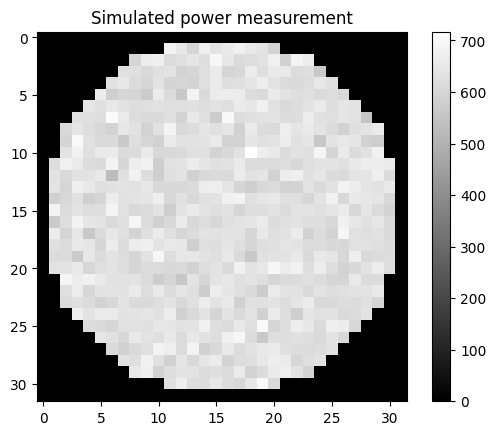

/Users/work/anaconda3/envs/jaxenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3741: RuntimeWarning: divide by zero encountered in negative
  if np.any(np.less(err, -err, out=res, where=(err == err))):
/Users/work/anaconda3/envs/jaxenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3741: RuntimeWarning: divide by zero encountered in equal
  if np.any(np.less(err, -err, out=res, where=(err == err))):
/Users/work/anaconda3/envs/jaxenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3741: RuntimeWarning: divide by zero encountered in less
  if np.any(np.less(err, -err, out=res, where=(err == err))):
/Users/work/anaconda3/envs/jaxenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3749: RuntimeWarning: divide by zero encountered in multiply
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/Users/work/anaconda3/envs/jaxenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3749: RuntimeWarning: divide by zero encountered in add
  low, high = de

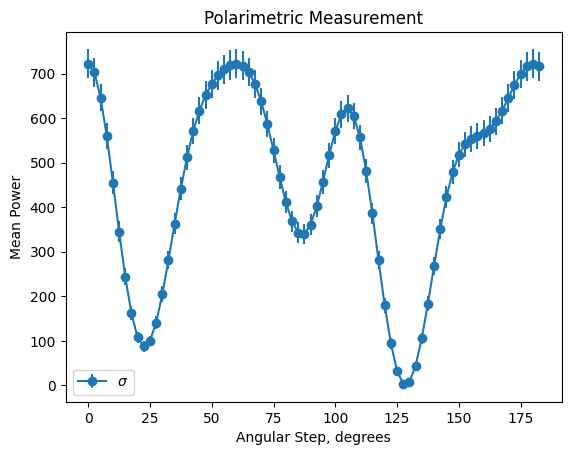

In [8]:
psg_angles = np.arange(0, 181 + STEPS_DEG, STEPS_DEG)

plt.figure()
plt.title("Simulated power measurement")
plt.imshow(mask * power_truth[4], cmap='grey')
plt.colorbar()
plt.show()

mean_power = np.mean(mask * power_truth, axis=(1, 2))
mean_std = []
for _p in power_truth:
    frame = np.copy(_p) - np.mean(_p[mask==1])
    mean_std.append(np.std(frame[mask==1]))

plt.figure()
plt.errorbar(psg_angles, mean_power, yerr=mean_std, marker='o', label=r'$\sigma$')
plt.xlabel('Angular Step, degrees')
plt.ylabel('Mean Power')
plt.title('Polarimetric Measurement')
plt.legend()
plt.show()

# Set up the Likelihood Function

Consider a collection of random variables $\vec{X} = x_1, x_2, x_3, ...$ which follow a Poisson distribution with expectation $\lambda$. The Probability distribution function is 

$$p(x_i | \lambda) = \frac{e^{-\lambda} \lambda^{x_{i}}}{x_{i}!}$$

Here $x_{i}$ would be our observed photons and $\lambda$ is what the model predicts the expectation value of the arriving photons would be. Next we compute the likelihood of all the events $x_{i}$ by taking the product of the PDFs.

$$ P(\lambda) = \prod_{i=0}^{N} p(x_i | \lambda) $$

By computing the log-likelihood, this can be a simple sum

$$ \mathcal{L} = ln (P(\lambda)) = -N \lambda + \sum_{i=0}^{N} x_i ln(\lambda) - \sum_{i=0}^{N} ln(x_i !)$$

In [9]:
# def factorial(x):

#     if x > 0:

#         return x * factorial(x-1)
    
#     else:
#         return 1
from scipy.special import factorial

def logpdf(lam, xi):

    if type(xi) == int:
        N = 1
        factorials = factorial(xi)
    else:
        N = xi.shape[0]

        # evaluate factorials
        # factorials = []
        # for x in xi:
        #     factorials.append(factorial(x))
        # factorials = np.asarray(factorials)
        factorials = factorial(xi)

    Nlam = N * lam
    sumxln = np.sum(xi * np.log(lam))


    sumlnxfac = np.sum(np.log(factorials))

    return -Nlam + sumxln - sumlnxfac

Test against the `scipy.stats` module

In [10]:
from scipy.stats import poisson
help(poisson.logpmf)

Help on method logpmf in module scipy.stats._distn_infrastructure:

logpmf(k, *args, **kwds) method of scipy.stats._discrete_distns.poisson_gen instance
    Log of the probability mass function at k of the given RV.
    
    Parameters
    ----------
    k : array_like
        Quantiles.
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information).
    loc : array_like, optional
        Location parameter. Default is 0.
    
    Returns
    -------
    logpmf : array_like
        Log of the probability mass function evaluated at k.



In [11]:
lams = [1, 2, 3]
xis = [2, 4, 6]

for l, x in zip(lams, xis):
    print('Scipy says = ', poisson.logpmf(x, l))
    print('Katsu says = ', logpdf(l, x))

Scipy says =  -1.6931471805599454
Katsu says =  -1.6931471805599454
Scipy says =  -2.4054651081081646
Katsu says =  -2.4054651081081646
Scipy says =  -2.987577480001443
Katsu says =  -2.987577480001443


Looks good to me, now we can do maximum likelihood stuff. What happens if we just throw in some random values?

In [12]:
x_model = [
    0, # starting angle psg pol
    0, # starting angle psg wvp
    np.pi / 2, # retardance psg wvp
    1, # error in psg wvp increment
    0, # starting angle psa pol
    0, # starting angle psa wvp
    np.pi / 2, # retardance psa wvp
    1 # error in psa wvp increment
]

# add some uniform random noise
x_model = np.asarray(x_model) + tnp.random.rand(len(x_model))

# Get expectation values
model_expectation = measurement(x_model, noisy=False)
model_expectation = np.moveaxis(model_expectation, -1, 0)

# Get the log likelihood
log_likelihood = []
for lam, xi in zip(model_expectation, power_truth):
    log_likelihood.append(poisson.logpmf(xi[mask==1], lam[mask==1]))

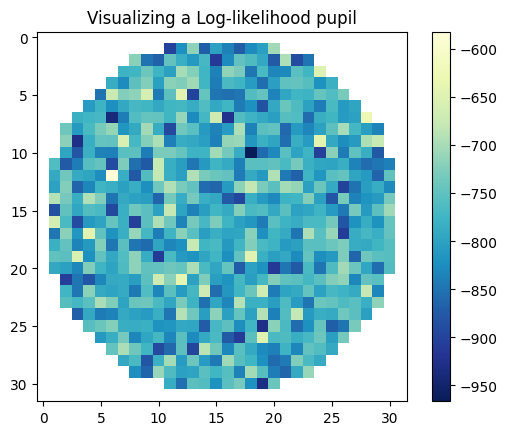

In [13]:
stuff_loglike = np.copy(mask)
stuff_loglike = stuff_loglike.at[mask==1].set(log_likelihood[30])

plt.figure()
plt.title("Visualizing a Log-likelihood pupil")
plt.imshow(stuff_loglike / mask, cmap="YlGnBu_r")
plt.colorbar()
plt.show()

Text(0.5, 0, 'Pixels')

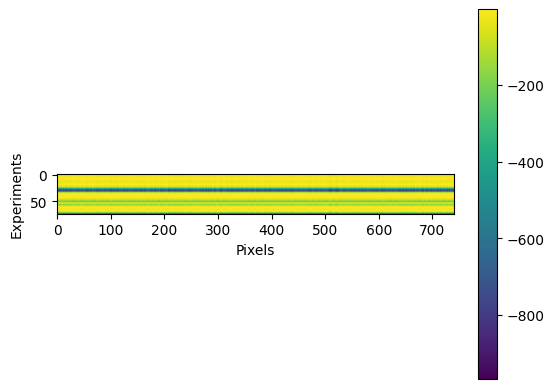

In [14]:
plt.imshow(np.asarray(log_likelihood))
plt.colorbar()
plt.ylabel("Experiments")
plt.xlabel("Pixels")

The log-likelihood gets really low. What happens if we feed this the true parameters?

In [15]:
# Get expectation values
model_expectation = measurement(x_truth, noisy=False)
model_expectation = np.moveaxis(model_expectation, -1, 0)

# Get the log likelihood
log_likelihood = []
for lam, xi in zip(model_expectation, power_truth):
    log_likelihood.append(poisson.logpmf(xi[mask==1], lam[mask==1]))

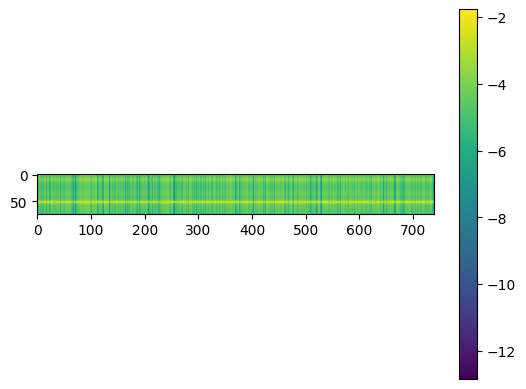

In [16]:
plt.imshow(np.asarray(log_likelihood))
plt.colorbar()

The likelihood gets orders of magniutde larger! So maximizing the likelihood does bring us closer to the true result. The next question is if we can get there via optimization, without knowing anything about the original state of the instrument.

# Attempting to do the calibration

We need an optimization scheme that returns a scalar value - maybe it is sufficient to sum over the Log Likelihoods?

In [17]:


from jax import value_and_grad
from jax.scipy.stats import poisson

def compute_likelihood(x):
    """Create simulated power measurement

    Parameters
    ----------
    x : list or array
        vector of model parameters

    Returns
    -------
    float
        negative log-likelihood of given model parameters
    """
    invert = False

    # Get a series of noisy power measurements
    power_truth = measurement(x_truth, noisy=True)

    # Get the power measurements the model expects
    power_model = measurement(x, noisy=False)
    power_model = np.moveaxis(power_model, -1, 0)

    # compute the Poisson log-likelihood
    log_likelihood = []
    for lam, xi in zip(power_model, power_truth):
        log_likelihood.append(poisson.logpmf(xi[mask==1], lam[mask==1]))

    # Sum the likelihoods of everything
    loglike = np.sum(np.asarray(log_likelihood))

    return -loglike


compute_likelihood_fg = value_and_grad(compute_likelihood)

In [18]:
%%timeit
compute_likelihood_fg(x_model)

1.33 s ± 334 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
from scipy.optimize import minimize
from tqdm import tqdm

MAX_ITERS = 100

def callback(xk):
    pbar.update(1)

with tqdm(total=MAX_ITERS) as pbar:
    results = minimize(compute_likelihood_fg, x0=np.asarray(x_model), callback=callback, method="L-BFGS-B", jac=True,
                       options={"maxiter": MAX_ITERS})

 33%|███▎      | 33/100 [00:55<01:52,  1.68s/it]


In [20]:
print(results)
print(x_truth)
labels = ["psg pol start angle", "psg wvp start angle", "psg wvp ret", "psg wvp err",
          "psa pol start angle", "psa wvp start angle", "psa wvp ret", "psa wvp err"]

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 249744.19511309307
        x: [-1.075e+00  4.958e-01  1.574e+00  1.090e+00  2.065e+00
             4.954e-01  1.572e+00  1.183e+00]
      nit: 33
      jac: [ 1.299e-01 -1.658e-01  5.835e-02  0.000e+00  9.288e-02
            -5.699e-02  4.242e-02  0.000e+00]
     nfev: 43
     njev: 43
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
[0, 0, 1.5707963267948966, 1, 0, 0, 1.5707963267948966, 1]


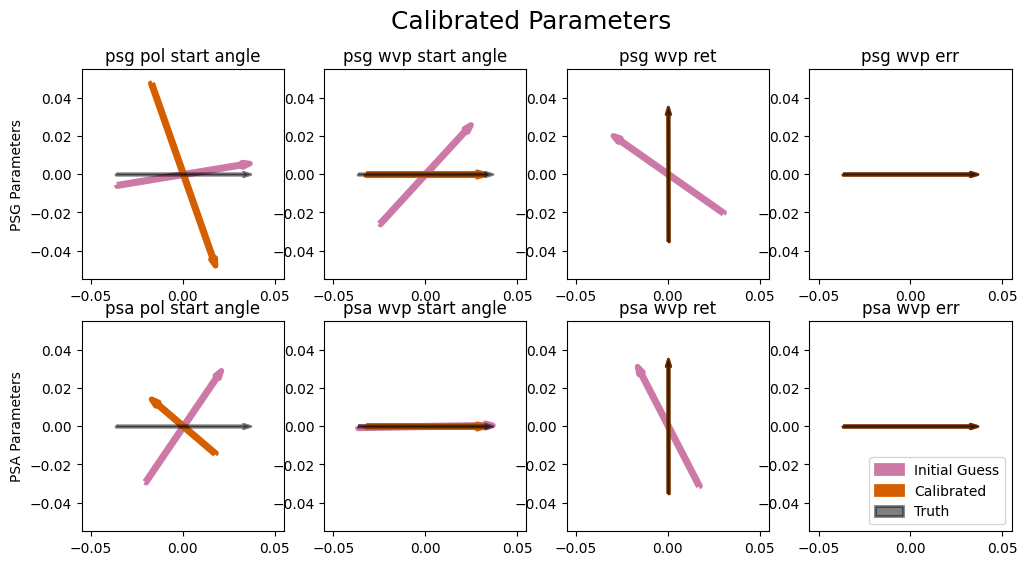

In [21]:
plt.style.use("default")
fig, axs = plt.subplots(figsize=[12,6], ncols=4, nrows=2)
fig.suptitle("Calibrated Parameters", fontsize=18)
for i, (xc, xt, xm, ax) in enumerate(zip(results.x, x_truth, x_model, axs.ravel())):

    ax.set_title(labels[i])
    if i == 3 or i == 7:
        ax.quiver(0, 0, 1, 0, label="Initial Guess", scale=1.5, pivot="middle", edgecolor="#CC79A7", color="#CC79A7", linewidth=2)
        ax.quiver(0, 0, 1, 0, label="Calibrated", scale=1.5, pivot="middle", edgecolor="#D55E00", color="#D55E00", linewidth=2)
        ax.quiver(0, 0, 1, 0, label="Truth", scale=1.5, pivot="middle", edgecolor="k", alpha=0.5, linewidth=2)
    elif i == 2 or i == 6:
        ax.quiver(0, 0, np.cos(xm), np.sin(xm), label="Initial Guess", scale=1.5, pivot="middle", edgecolor="#CC79A7", color="#CC79A7", linewidth=4)
        ax.quiver(0, 0, np.cos(xc), np.sin(xc), label="Calibrated", scale=1.5, pivot="middle", edgecolor="#D55E00", color="#D55E00", linewidth=2)
        ax.quiver(0, 0, np.cos(xt), np.sin(xt), label="Truth", scale=1.5, pivot="middle", edgecolor="k", alpha=0.5, linewidth=2)
    else:
        diff_model_tx = np.cos(xm) #- np.cos(x_model[5])
        diff_model_ty = np.sin(xm) # - np.sin(x_model[5])
        norm = np.sqrt(diff_model_tx**2 + diff_model_tx**2)
        # diff_model_tx /= norm
        # diff_model_ty /= norm
        ax.quiver(0, 0, diff_model_tx, diff_model_ty, label="Initial Guess", scale=1.5, pivot="middle", edgecolor="#CC79A7", color="#CC79A7", linewidth=4)
        ax.quiver(0, 0, np.cos(xc), np.sin(xc) - np.sin(results.x[5]), label="Calibrated", scale=1.5, pivot="middle", edgecolor="#D55E00", color="#D55E00", linewidth=4)
        ax.quiver(0, 0, np.cos(xt), np.sin(xt), label="Truth", scale=1.5, pivot="middle", edgecolor="k", alpha=0.5, linewidth=2)
axs[0,0].set_ylabel("PSG Parameters")
axs[1,0].set_ylabel("PSA Parameters")
plt.legend(loc="lower right")
plt.show()

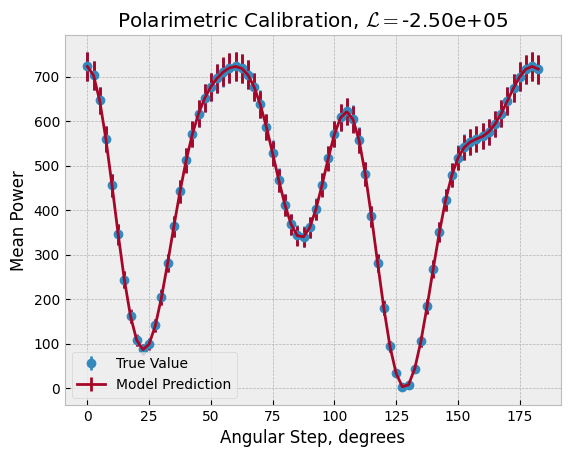

In [22]:
power_calibrated = measurement(results.x, noisy=True)
mean_calirbated = np.mean(mask * power_calibrated, axis=(1, 2))
cal_std = []

mean_power = np.mean(mask * power_truth, axis=(1, 2))
mean_std = []
for _p, _c in zip(power_truth, power_calibrated):
    frame = np.copy(_p) - np.mean(_p[mask==1])
    mean_std.append(np.std(frame[mask==1]))

    frame = np.copy(_c) - np.mean(_c[mask==1])
    cal_std.append(np.std(frame[mask==1]))

plt.style.use("bmh")
plt.figure()
plt.errorbar(psg_angles, mean_power, yerr=mean_std, marker='o', label="True Value", linestyle="None")
plt.errorbar(psg_angles, mean_calirbated, yerr=cal_std, label="Model Prediction", alpha=1)
plt.xlabel('Angular Step, degrees')
plt.ylabel('Mean Power')
plt.title('Polarimetric Calibration, '+r'$\mathcal{L}=$'+f"{-results.fun:.2e}")
plt.legend()
plt.show()

In [23]:
# Try visualize the covariance matrix?
from jax import hessian

FIM = hessian(compute_likelihood)
COV = - np.linalg.inv(FIM(results.x))

In [24]:
FIM(results.x).shape

(8, 8)

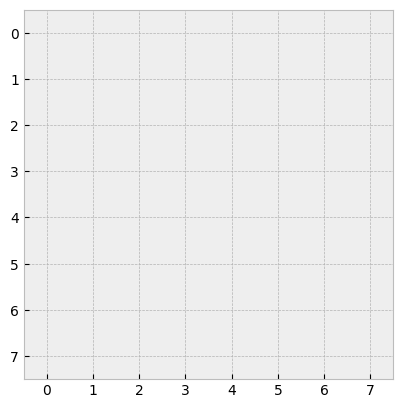

In [25]:
plt.imshow(COV)

In [26]:
from katsu.mueller import stokes_from_parameters

s_lhc = stokes_from_parameters(1, 0, 0, 1)
s_rhc = stokes_from_parameters(1, 0, 0, -1)

circular_polarizer = linear_polarizer(0) @ linear_retarder(np.radians(45), np.pi/2)
circular_polarizer_neg = linear_polarizer(0) @ linear_retarder(np.radians(-45), np.pi/2)
print("Analyze Left Circular")
print(20*"-")
print("Left Circular In")
print((circular_polarizer @ s_lhc).T)
print("Right Circular In")
print((circular_polarizer @ s_rhc).T)
print(20*"-")
print("Analyze Right Circular")
print(20*"-")
print("Left Circular In")
print((circular_polarizer_neg @ s_lhc).T)
print("Right Circular In")
print((circular_polarizer_neg @ s_rhc).T)
print(20*"-")

Analyze Left Circular
--------------------
Left Circular In
[[0. 0. 0. 0.]]
Right Circular In
[[1. 1. 0. 0.]]
--------------------
Analyze Right Circular
--------------------
Left Circular In
[[1. 1. 0. 0.]]
Right Circular In
[[0. 0. 0. 0.]]
--------------------


In [31]:
def wollaston_forward(stokes):

    wollaston_h = linear_polarizer(0)
    wollaston_v = linear_polarizer(np.radians(90))

    stokes_analyze_h = wollaston_h @ stokes
    stokes_analyze_v = wollaston_v @ stokes

    p_h = stokes_analyze_h[0]
    p_v = stokes_analyze_v[0]

    return p_h, p_v

# Initialize Stokes Vectors to Test
s_lhc = stokes_from_parameters(1, 0, 0, -1)
s_rhc = stokes_from_parameters(1, 0, 0, 1)

# Propagate through a fixed QWP
qwp_fixed = linear_retarder(np.radians(-45), np.pi / 2)

s_lhc = (qwp_fixed @ s_lhc)
s_rhc = (qwp_fixed @ s_rhc)

# propagate through wollaston
ph_l, pv_l = wollaston_forward(s_lhc)
ph_r, pv_r = wollaston_forward(s_rhc)

# Measure V differentially
print("Should be -1")
print(ph_l - pv_l)
print("Should be 1")
print(ph_r - pv_r)


Should be -1
[-1.]
Should be 1
[1.]
